In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import nibabel as nib, numpy, pathlib
from data_loader import *
from keras_unet.utils import plot_imgs

Using TensorFlow backend.


In [2]:
path_string = ""
data_path = Path(path_string)

img_path = data_path / "imagesTr"
label_path = data_path / "labelsTr"

## Dataset Exploration

In [3]:
num_samples = 281

# importing training data
print("... preparing data")
print("... importing training data")
data, num_scans = load_data(img_path, num_samples=num_samples)

# importing labels
print("... importing labels")
segmentation_labels, num_labels = load_data(label_path, num_samples=num_samples)

assert num_scans == num_labels
print("... import done")

... preparing data
... importing training data
... importing labels
... import done


### Mean Voxel Size

In [4]:
zooms = []
for file_name, nifti_img, in data.items():
    zooms.append(nifti_img.header.get_zooms())

zooms_x = [i[0] for i in zooms]
zooms_y = [i[1] for i in zooms]
zooms_z = [i[2] for i in zooms]

In [5]:
print(f"mean voxel sizes: x: {np.mean(zooms_x):.4f} y: {np.mean(zooms_y):.4f} z: {np.mean(zooms_z):.4f}")
print(f"standard deviation voxel sizes: x: {np.std(zooms_x):.4f} y: {np.std(zooms_y):.4f} z: {np.std(zooms_z):.4f}")

mean voxel sizes: x: 0.8124 y: 0.8124 z: 2.9002
standard deviation voxel sizes: x: 0.0941 y: 0.0941 z: 0.9790


### Pancreas height (z-axis)

In [6]:
z_heights = []
scan_heights = []
for file_name, nifti_img, in segmentation_labels.items():
    np_label = nifti_img.get_fdata()
    _, _, _, _, zmin, zmax = bbox_dim_3D(np_label)
    z_height = zmax - zmin
    z_heights.append(z_height)
    scan_heights.append(np_label.shape[2])
    nifti_img.uncache()

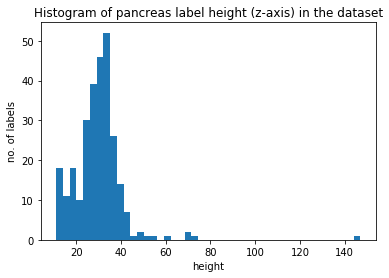

Mean height of pancreas 30.3 ± 11.6
Mean height of total scan 95.1 ± 48.4


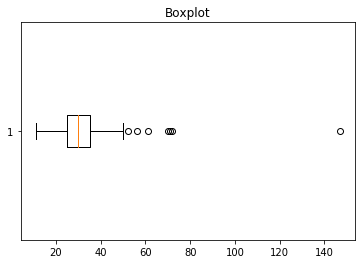

In [7]:
import matplotlib.pyplot as plt

plt.hist(z_heights, bins='auto')
plt.title("Histogram of pancreas label height (z-axis) in the dataset")
plt.ylabel("no. of labels")
plt.xlabel("height")
#plt.savefig("pancreas_height_resampled_2x2x1.png", dpi=500)
plt.show()
print(f"Mean height of pancreas {np.mean(z_heights):.1f} ± {np.std(z_heights):.1f}")
print(f"Mean height of total scan {np.mean(scan_heights):.1f} ± {np.std(scan_heights):.1f}")

fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot')
ax1.boxplot(z_heights, vert=False)
plt.show()

### Class Imbalance

In [8]:
X_partial, y_partial, X_val, y_val, X_test, y_test = prepare_data(
                    path_string="/Users/moritzknolle/Desktop/Uni/deep_learning_adenocarcinoma/Data/Task07_Pancreas",
                    num_samples=281,
                    res=256,
                    crop_height=2,
                    res_z=48,
                    mode="2D",
                    label_mode="seg")

... preparing data
... importing training data
... importing labels 
... preparing training data and labels(seg)
... total amount of training data: 281
... total amount of labels: 281

train set: 196 scans and 196 label volumes
test set: 85 scans and 85 label volumes
train set was split into partial train set: 176 scans and 176 label volumes
validation set: 20 scans and 20 label volumes
... converting data to 2D slices
... finished preparing data


In [ ]:
import numpy as np
def get_class_imbalance(arr:np.array):
    ones = np.count_nonzero(arr)
    total = arr.flatten().shape[0]

    imbalance_ratio = ones/total
    return imbalance_ratio

y_partial_imb = get_class_imbalance(y_partial)
y_val_imb = get_class_imbalance(y_val)
y_test_imb = get_class_imbalance(y_test)
imbs = {"y_partial":y_partial_imb, "y_val":y_val_imb, "y_test":y_test_imb}

for name, imb_ratio in imbs.items():
    print(f"Class imbalance for {name}:  {imb_ratio*100:.4f}%")

## Comparison of Label Quality at different Voxel Sizing and Spacing

### **Unresampled Labels**

In [17]:
slice_index = 20
X_partial, y_partial, X_val, y_val, X_test, y_test = prepare_data(
                    path_string="/Users/moritzknolle/Desktop/Uni/deep_learning_adenocarcinoma/Data/Task07_Pancreas",
                    num_samples=10, 
                    res= 256,
                    height=32,
                    mode="3D",
                    label_mode="seg")

... preparing data
... importing training data
... importing labels 
... preparing training data and labels(seg)
... total amount of training data: 10
... total amount of labels: 10

train set: 7 scans and 7 label volumes
test set: 3 scans and 3 label volumes
train set was split into partial train set: 4 scans and 4 label volumes
validation set: 3 scans and 3 label volumes


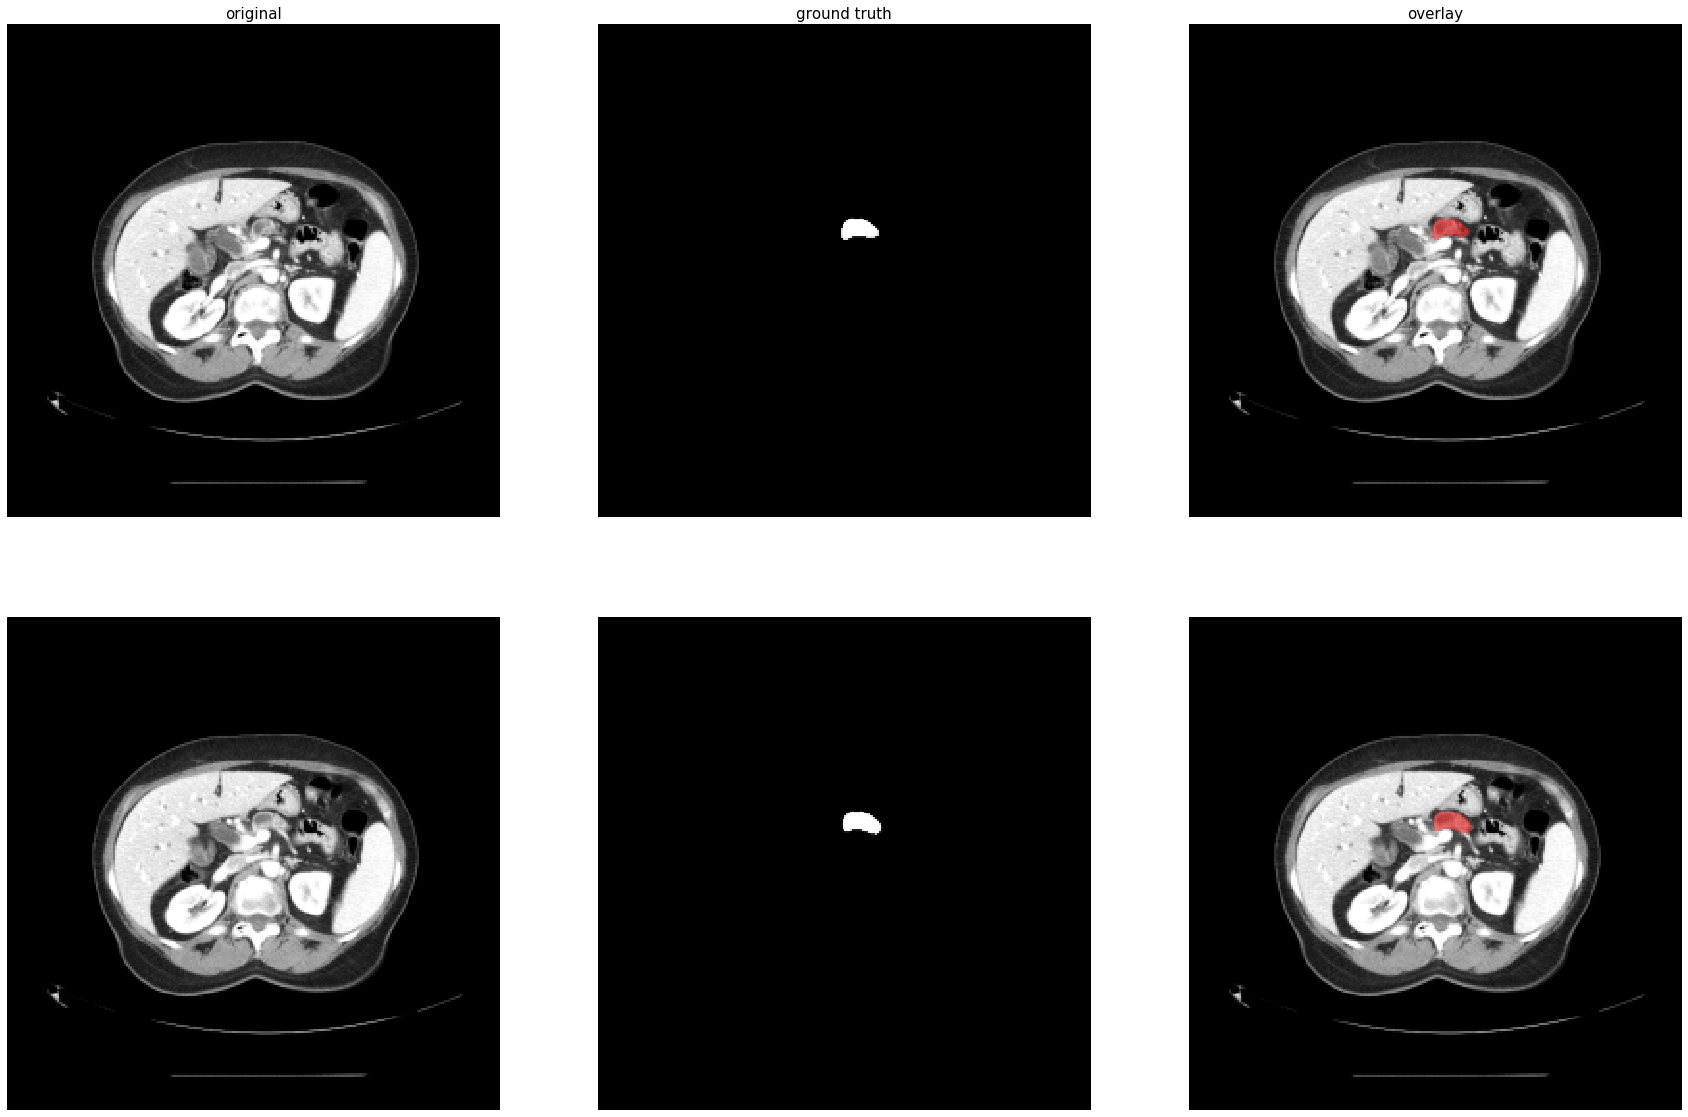

In [20]:
plot_imgs(np.moveaxis(X_partial[0, ..., slice_index:], 2, 0), 
          np.moveaxis(y_partial[0, ..., slice_index:], 2, 0),
          nm_img_to_plot=2,
          figsize=10)

## **Resampled to 1x1x1**

In [21]:
X_partial_1, y_partial_1, X_val_1, y_val_1, X_test_1, y_test_1 = prepare_data(
                    path_string="/Users/moritzknolle/Desktop/Uni/deep_learning_adenocarcinoma/Data/Task07_Pancreas/resampling_experiment/resampled_1x1x1/",
                    num_samples=10, 
                    res= 256,
                    height=32,
                    mode="3D",
                    label_mode="seg")

... preparing data
... importing training data
... importing labels 
... preparing training data and labels(seg)
... total amount of training data: 10
... total amount of labels: 10

train set: 7 scans and 7 label volumes
test set: 3 scans and 3 label volumes
train set was split into partial train set: 4 scans and 4 label volumes
validation set: 3 scans and 3 label volumes


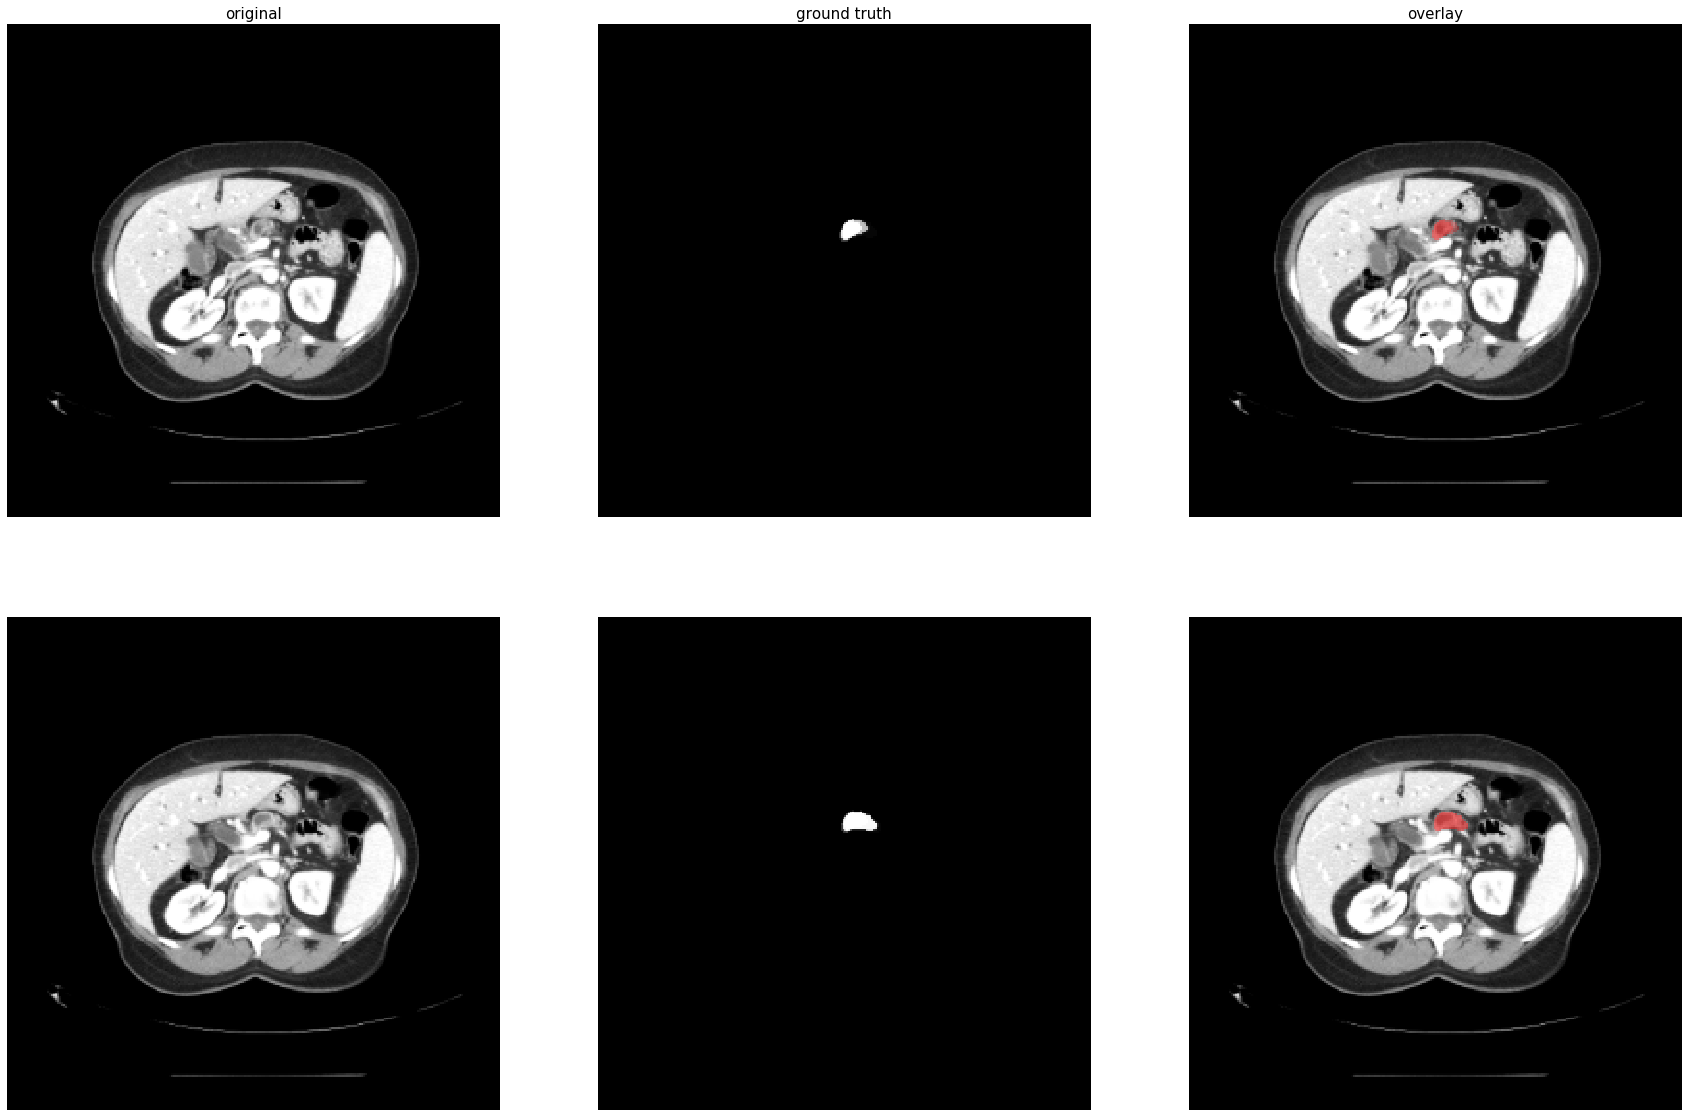

In [22]:
plot_imgs(np.moveaxis(X_partial_1[0, ..., slice_index:], 2, 0), np.moveaxis(y_partial_1[0, ..., slice_index:], 2, 0),
          nm_img_to_plot=2,
          figsize=10)

## **Resampled to 1x1x3**

In [23]:
X_partial_3, y_partial_3, X_val_3, y_val_3, X_test_3, y_test_3 = prepare_data(
                    path_string="/Users/moritzknolle/Desktop/Uni/deep_learning_adenocarcinoma/Data/Task07_Pancreas/resampling_experiment/resampled_1x1x3/",
                    num_samples=10, 
                    res= 256,
                    height=32,
                    mode="3D",
                    label_mode="seg")

... preparing data
... importing training data
... importing labels 
... preparing training data and labels(seg)
... total amount of training data: 10
... total amount of labels: 10

train set: 7 scans and 7 label volumes
test set: 3 scans and 3 label volumes
train set was split into partial train set: 4 scans and 4 label volumes
validation set: 3 scans and 3 label volumes


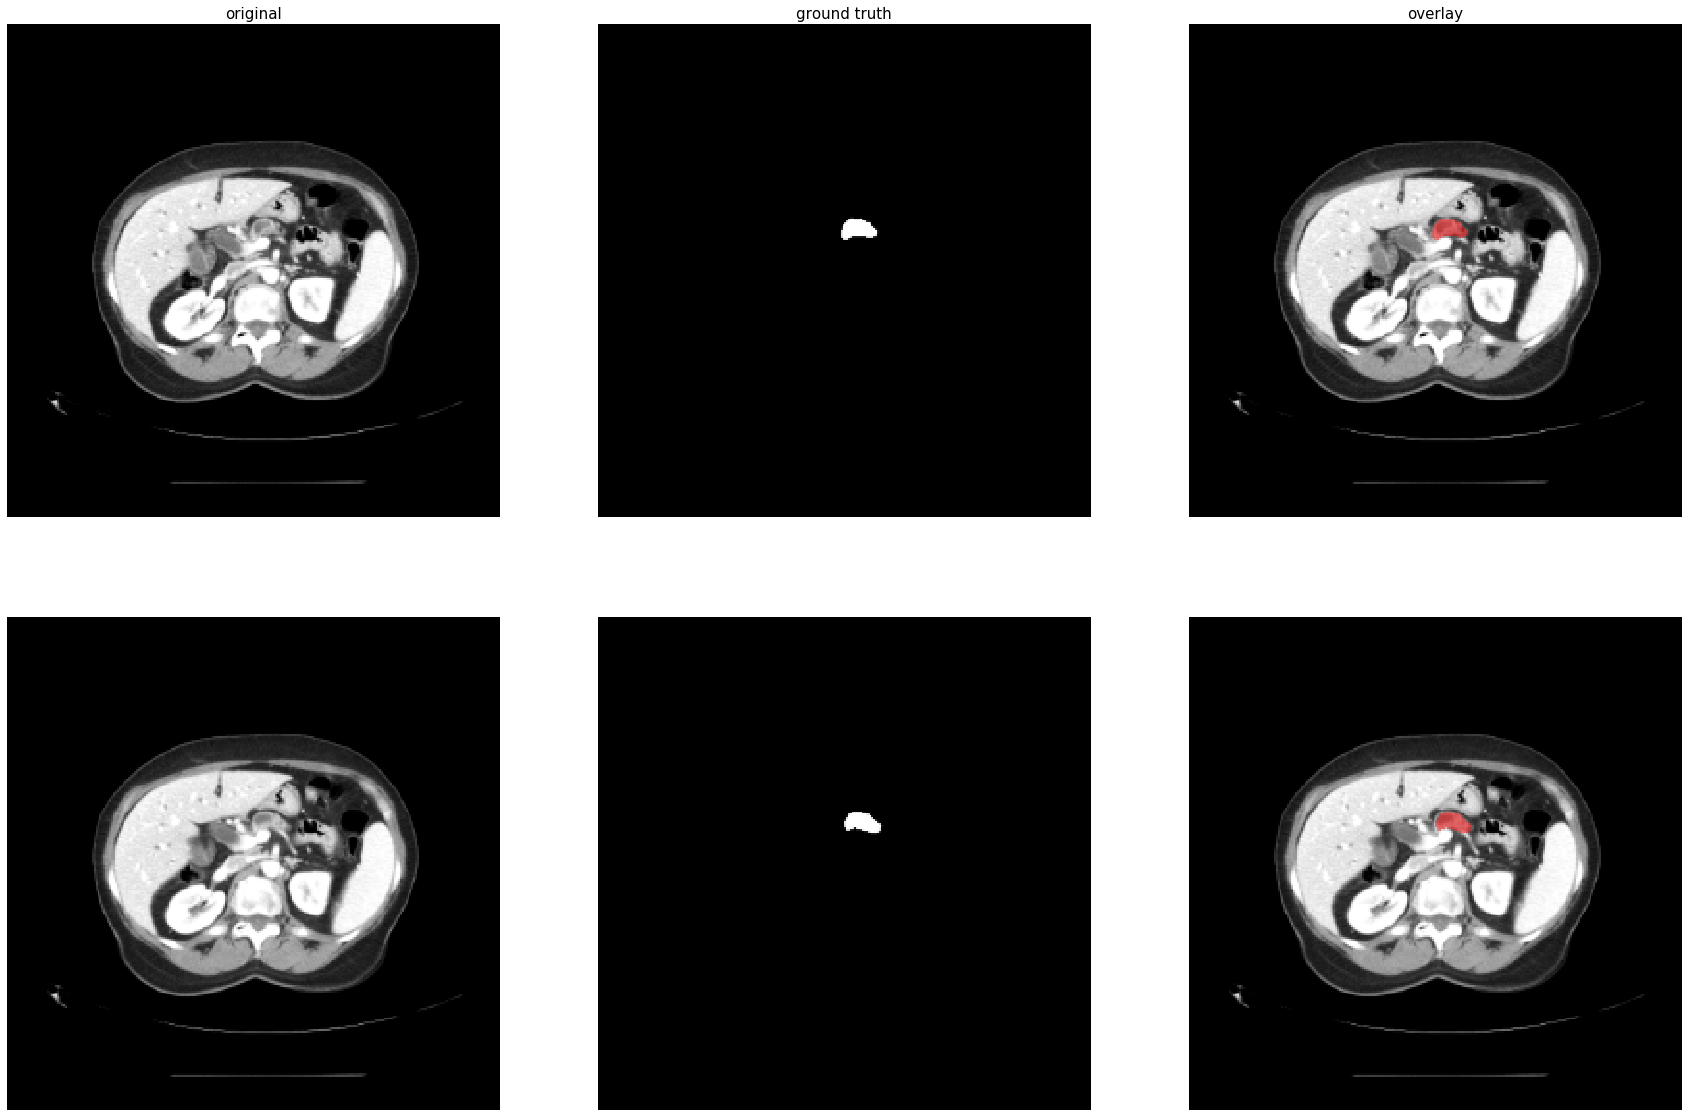

In [25]:
plot_imgs(np.moveaxis(X_partial_3[0, ..., slice_index:], 2, 0), np.moveaxis(y_partial_3[0, ..., slice_index:], 2, 0),
          nm_img_to_plot=2,
          figsize=10)

## 3D Label Visualisation

In [26]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [41]:
#loading in a full size label for comparison
full_res_label = nib.load("/Users/moritzknolle/Desktop/Uni/deep_learning_adenocarcinoma/Data/Task07_Pancreas/labelsTr/pancreas_001.nii.gz")
full_res_label = full_res_label.get_fdata()

In [42]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def display_seg_label_3d(image, angle=0, threshold=0.1, title="3D-Plot of Segmentation Label"):
    """ Convenience function to create a 3D-plot of the Segmentation Labels """
    verts, faces, x, y = measure.marching_cubes_lewiner(image, threshold, allow_degenerate=True)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, image.shape[0])
    ax.set_ylim(0, image.shape[1])
    ax.set_zlim(0, image.shape[2])
    plt.title(title)
    ax.view_init(10, angle)
    plt.show()

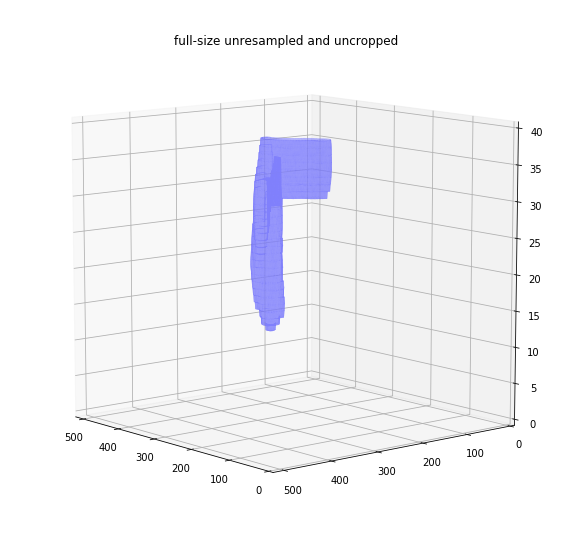

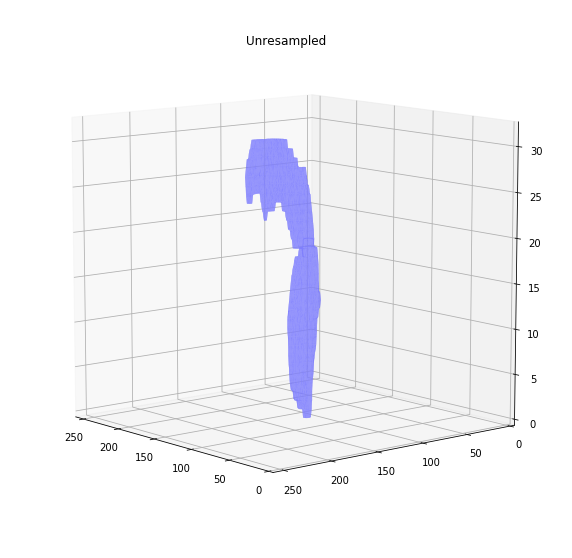

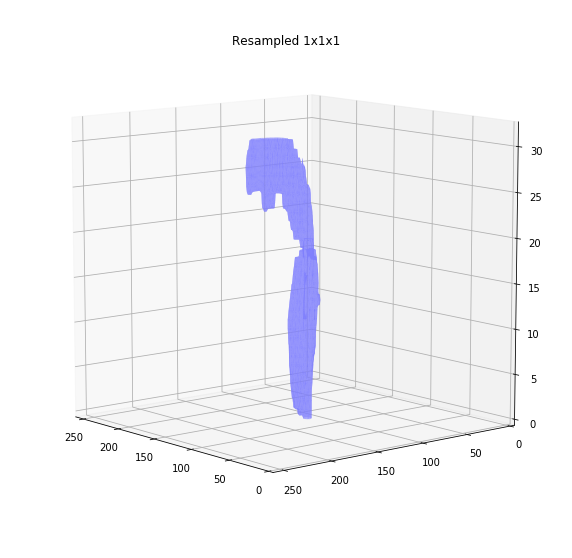

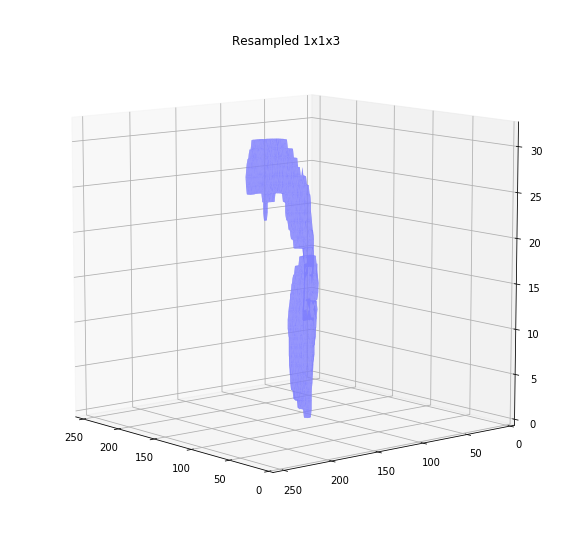

In [43]:
angle=140
display_seg_label_3d(full_res_label[..., 20:60], angle=angle, title= "full-size unresampled and uncropped")
display_seg_label_3d(y_partial[0], angle=angle, title= "Unresampled")
display_seg_label_3d(y_partial_1[0], angle=angle, title= "Resampled 1x1x1")
display_seg_label_3d(y_partial_3[0], angle=angle, title= "Resampled 1x1x3")